In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
pd.set_option('display.max_rows', 250) # so that we can see all of the different experiments available

In [70]:
 # Different variable options : 
#'mrro' - runoff
#'snw' - SWE
 #hfls - latent heat
 # mrros - surface runoff
 # mrso - soil moisture
 # pr - precipitation
 # tas - mean daily air temperature
 # prra - rainfall rate
 # prsn - snowfall rate

variable_of_interest = 'mrro'

In [292]:
cat = col.search(experiment_id=['ssp585', 'historical', 'ssp126', 'ssp245', 'ssp370'],#, 'historical'], 
                 table_id='day',             
                 variable_id=variable_of_interest,
                institution_id='NCAR') 
# this is a hack just to get around the different grid_label strings
cat.df['grid_label']='gn'

In [72]:
future_slice = slice('2070','2099')
historical_slice = slice('1970','1999')

In [ ]:
CMIP.IPSL.IPSL-CM6A-LR.historical.day.gr

In [95]:
dset_dict

{'ScenarioMIP.CCCma.CanESM5.ssp585.day.gn': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 64, lon: 128, member_id: 1, time: 31390)
 Coordinates:
     lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
     time_bnds  (time, bnds) float64 dask.array<chunksize=(15695, 2), meta=np.ndarray>
     lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
   * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
   * time       (time) int64 0 1 2 3 4 5 ... 31384 31385 31386 31387 31388 31389
   * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
   * member_id  (member_id) <U8 'r1i1p1f1'
 Dimensions without coordinates: bnds
 Data variables:
     mrro       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 6067, 64, 128), meta=np.ndarray>
 Attributes:
     CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
     CCCma_parent_runid:          rc3.1-his01
     CCCma_pycmor_

In [293]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    # Add dataset to dictionary, selecting first member_id for each simulation since we'll just use
    # one ensemble member right now
    ds_dict[name] = ds.isel(member_id=0)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 5 group(s)


In [298]:
def change_annual_mean(historic, future):
    return (future.mean(dim='time')-historic.mean(dim='time'))/historic.mean(dim='time') * 100

In [282]:
# this accesses the unique GCM ids
change_dict = {}
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    if institution_id == 'EC-Earth-Consortium': # this one just is doing something funky with its latitudes
        continue
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, source_id)][variable_of_interest]
    working_ds_future = ds_dict['ScenarioMIP.{}.{}.ssp585.day.gn'.format(institution_id, source_id)][variable_of_interest]
    runoff_historical = working_ds_historical.sel(time=historical_slice)
    runoff_future = working_ds_future.sel(time=future_slice)
    function = change_annual_mean
    change_dict[source_id] = function(historical, future)
#         except:
#             continue

KeyError: 'ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp585.day.gn'

In [246]:
for experiment in list(ds_dict.keys()):
    if 'Scenario' in experiment:
        print(experiment)

ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.day.gn
ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.day.gn
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.day.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.day.gn
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.day.gn
ScenarioMIP.NCAR.CESM2.ssp585.day.gn
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.day.gn
ScenarioMIP.MRI.MRI-ESM2-0.ssp585.day.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.day.gn
ScenarioMIP.MIROC.MIROC6.ssp585.day.gn
ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.day.gn
ScenarioMIP.CCCma.CanESM5.ssp585.day.gn


In [296]:
ds_dict.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp370.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp126.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.day.gn'])

In [299]:
historical_low = calculate_low_runoff(ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].sel(
    time=historical_slice))
future_low = calculate_low_runoff(ds_dict['ScenarioMIP.NCAR.CESM2.ssp585.day.gn'].sel(
    time=future_slice))
low_warming_low = calculate_low_runoff(ds_dict['ScenarioMIP.NCAR.CESM2.ssp126.day.gn'].sel(
    time=future_slice))

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWa

In [300]:
change = ( future_low - historical_low ) / (historical_low) * 100

In [309]:
np.min(change.mrro.values)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


nan

In [310]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr
ax.set_global()
ax.coastlines()
q = change.mrro.plot(ax=ax, 
                                transform=ccrs.PlateCarree(), 
                                vmin=-100, vmax=100, 
                                cmap='RdBu')

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Global patterns of change in low runnof',fontsize=16, ha='center');
plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


Error in callback <function flush_figures at 0x7fa2c24095f0> (for post_execute):


KeyboardInterrupt: 

In [314]:
import gcsfs
import fsspec
import xarray as xr

with xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto') as ds:
    print(ds.vars)

AttributeError: 'Dataset' object has no attribute 'vars'

In [315]:
ds = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto')

In [317]:
ds.variables

Frozen({'asn': <xarray.Variable (time: 350640, latitude: 721, longitude: 1440)>
dask.array<zarr, shape=(350640, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:  Snow albedo
    units:      (0 - 1), 'd2m': <xarray.Variable (time: 350640, latitude: 721, longitude: 1440)>
dask.array<zarr, shape=(350640, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:  2 metre dewpoint temperature
    units:      K, 'e': <xarray.Variable (time: 350640, latitude: 721, longitude: 1440)>
dask.array<zarr, shape=(350640, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:      Evaporation
    standard_name:  lwe_thickness_of_water_evaporation_amount
    units:          m of water equivalent, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 721)>
array([ 90.  ,  89.75,  89.5 , ..., -89.5 , -89.75, -90.  ], dtype=float32)
Attributes:
    l

In [291]:
low_warming_low - historical_low

<xarray.Dataset>
Dimensions:  (lat: 0, lon: 0)
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 
Data variables:
    mrro     (lat, lon) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>

In [302]:
change = ( low_warming_low - historical_low ) / (historical_low) * 100

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


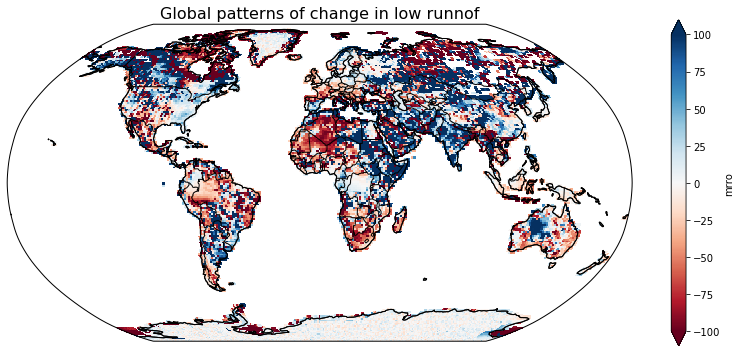

In [303]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr
ax.set_global()
ax.coastlines()
q = change.mrro.plot(ax=ax, 
                                transform=ccrs.PlateCarree(), 
                                vmin=-100, vmax=100, 
                                cmap='RdBu')

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Global patterns of change in low runnof',fontsize=16, ha='center');
# plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

AttributeError: 'numpy.ndarray' object has no attribute 'set_global'

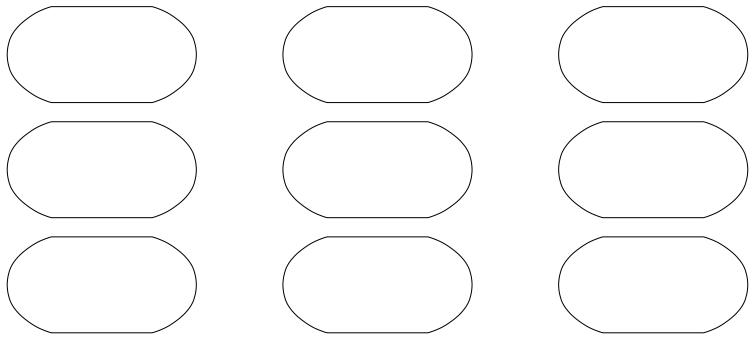

In [206]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for (i, source_id) in enumerate(change_dict.keys()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    q = change_dict[source_id].plot(ax=ax, 
                                    transform=ccrs.PlateCarree(), 
                                    vmin=-100, vmax=100, 
                                    cmap='RdBu', add_colorbar=False) # plot a colormap in transformed coordinates

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    plt.title('Patterns of global annual runnof change',fontsize=16, ha='center');
    # plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

#To-do list
* seasonal cycle (daily average for an average year within historical and future periods)
* function for each of these temporal metrics:
1. change in centroid of timing
1. change in lowest 30 day period magnitude
1. total deviation from the mean
1. duration of low flow
* function for each of these spatiotemporal metrics:
1. within a given basin what is the variability - to-do in this is figureing out shapefile masking for river basins